# Investigating the impact of brain atrophy on survival in Alzheimer's disease

&emsp;
This notebook is divided into the following topics:
1) Predict survival probability using the Kaplan-Meier estimate for controls, patients with LMCI or AD 
2) Investigate features that impact the survival using the Cox Proportional-Hazards model
2) Investigate the cut-off of regional atrophy that determines low versus high survival in patients with AD
&emsp;

Data used in preparation of this article were obtained from the Alzheimer’s Disease Neuroimaging Initiative
(ADNI) database (adni.loni.usc.edu). As such, the investigators within the ADNI contributed to the design
and implementation of ADNI and/or provided data but did not participate in analysis or writing of this report.
A complete listing of ADNI investigators can be found at:
http://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Acknowledgement_List.pdf

### 1) Predict survival probability using the Kaplan-Meier estimate for controls, patients with LMCI or AD 

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import os, sys
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from datetime import datetime
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

In [2]:
#Import the dataset
ADNIMERGE0=pd.read_csv('ADNIMERGE.csv',low_memory=False)
WD_Reason=pd.read_csv('WD_Reason_TREATDIS.csv',low_memory=False)
ADNIMERGE1=pd.merge(ADNIMERGE0,WD_Reason,on='RID',how='inner')

<AxesSubplot:>

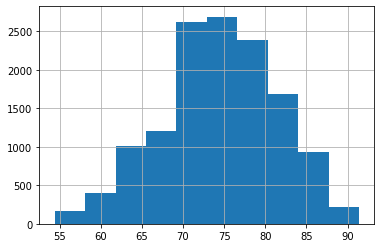

In [3]:
#Check distribution of Age
ADNIMERGE1.AGE.hist()

In [4]:
#Get list of subjects 
ADNIMERGE_subjs_list=ADNIMERGE1.PTID.unique()

In [5]:
#Create a function that gets the max years since baseline indices and translates it to the last entry
def get_max_idx(subjs_list,data):
    max_idx_bl_years=[]
    for subj in subjs_list:
        df=data[data['PTID'].isin([f'{subj}'])]
        subj_idx_max=df.Years_bl.idxmax()
        max_idx_bl_years.append(subj_idx_max)
    return max_idx_bl_years

In [6]:
ADNIMERGE_max_idx_bl_years=get_max_idx(ADNIMERGE_subjs_list,ADNIMERGE1)

In [7]:
#Assign Survival=1 to the max years since baseline or 0 otherwise
ADNIMERGE1['Suvival']=0
ADNIMERGE1.loc[ADNIMERGE_max_idx_bl_years,'Suvival']=1


In [8]:
#Check if subject' death is recorded and create new column as 'death'
ADNIMERGE_dead_idx=ADNIMERGE1.index[(ADNIMERGE1['Suvival'] == 1) &  (ADNIMERGE1['WDREASON']=='2')].tolist()
ADNIMERGE1['death']=0
ADNIMERGE1.loc[ADNIMERGE_dead_idx,'death']=1

In [10]:
CN_data=ADNIMERGE1[ADNIMERGE1['DX_bl'].isin(['CN'])]
CN_data.shape
LMCI_data=ADNIMERGE1[ADNIMERGE1['DX_bl'].isin(['LMCI'])]
LMCI_data.shape
AD_data=ADNIMERGE1[ADNIMERGE1['DX_bl'].isin(['AD'])]
AD_data.shape

(1754, 135)

In [11]:
ADNIMERGE1['DX_bl']

0        CN
1        CN
2        CN
3        CN
4        CN
         ..
13301    CN
13302    CN
13303    CN
13304    CN
13305    AD
Name: DX_bl, Length: 13306, dtype: object

In [12]:
#Check if any CN transform to LMCI or AD
CN_to_LMCI=LMCI_data[LMCI_data['PTID'].isin(CN_data['PTID'])]
print(CN_to_LMCI.shape)
CN_to_AD=AD_data[AD_data['PTID'].isin(CN_data['PTID'])]
CN_to_AD.shape

(0, 135)


(0, 135)

Shape[0] of CN_to_AD is 0, therefore no controls transform to LMCI or AD

<AxesSubplot:xlabel='timeline'>

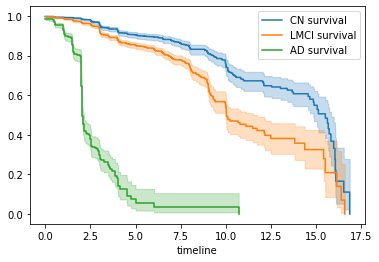

In [14]:
#Fit for plotting 'Suvival'
km = KaplanMeierFitter() 
km.fit(CN_data['Years_bl'], CN_data['Suvival'], label='CN survival')
a1 = km.plot()

km.fit(LMCI_data['Years_bl'], LMCI_data['Suvival'], label='LMCI survival')
a2=km.plot(ax=a1)

km.fit(AD_data['Years_bl'], AD_data['Suvival'], label='AD survival')
km.plot(ax=a2)

<AxesSubplot:xlabel='timeline'>

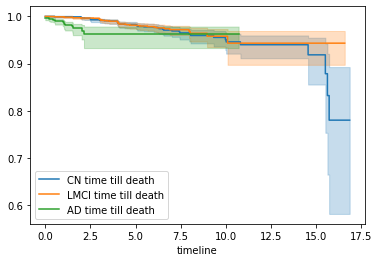

In [15]:
#Fit for plotting 'death'
km = KaplanMeierFitter() 
km.fit(CN_data['Years_bl'], CN_data['death'], label='CN time till death')
a1 = km.plot()

km.fit(LMCI_data['Years_bl'], LMCI_data['death'], label='LMCI time till death')
a2=km.plot(ax=a1)

km.fit(AD_data['Years_bl'], AD_data['death'], label='AD time till death')
km.plot(ax=a2)

In [16]:
#Fit a separate model and predict survival for a range of years
#Controls
km1 = KaplanMeierFitter() 
km1.fit(CN_data['Years_bl'], CN_data['Suvival'], label='CN survival')
km1.predict([0,3,6,10,15,20])

0     0.997031
3     0.960709
6     0.895334
10    0.758956
15    0.548505
20    0.000000
Name: CN survival, dtype: float64

In [17]:
#Patients with AD
km2 = KaplanMeierFitter() 
km2.fit(AD_data['Years_bl'], AD_data['Suvival'], label='AD survival')
km2.predict([0,3,6,10,15,20])

0     0.985747
3     0.301217
6     0.054627
10    0.036418
15    0.000000
20    0.000000
Name: AD survival, dtype: float64

### 2) Investigate features that impact the survival using the Cox Proportional-Hazards model

In [18]:
from lifelines import CoxPHFitter
data_cox_hz=AD_data[['APOE4','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','Years_bl','Suvival','AGE','ICV','death']]
data_cox_hz=data_cox_hz.dropna()
cph=CoxPHFitter()
cph.fit(data_cox_hz,'Years_bl',event_col='death')
cph.print_summary()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column Suvival have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, 'Suvival'].var())
>>> print(df.loc[~events, 'Suvival'].var())

A very low variance means that the column Suvival completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.342. This may imply non-unique solutions to the 

<lifelines.CoxPHFitter: fitted with 879 total observations, 871 right-censored observations>
             duration col = 'Years_bl'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 879
number of events observed = 8
   partial log-likelihood = -30.91
         time fit was run = 2023-03-10 16:31:20 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
APOE4        -0.65       0.52       0.67            -1.96             0.66                 0.14                 1.94
Ventricles    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Hippocampus   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
WholeBrain    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Entorhinal   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Fusiform      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MidTemp      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Suvival      19.46   2.82e+08    2331.82         -4550.83          4589.75                 0.00                  inf
AGE           0.03       1.03       0.06            -0.08             0.14                 0.92                 1.15
ICV          -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

              cmp to     z    p   -log2(p)
covariate                                 
APOE4           0.00 -0.97 0.33       1.58
Ventricles      0.00  0.96 0.34       1.57
Hippocampus     0.00  0.89 0.37       1.43
WholeBrain      0.00  1.51 0.13       2.93
Entorhinal      0.00 -0.27 0.78       0.35
Fusiform        0.00  1.80 0.07       3.79
MidTemp         0.00 -1.65 0.10       3.32
Suvival         0.00  0.01 0.99       0.01
AGE             0.00  0.49 0.62       0.69
ICV             0.00 -2.16 0.03       5.04
---
Concordance = 0.96
Partial AIC = 81.82
log-likelihood ratio test = 34.00 on 10 df
-log2(p) of ll-ratio test = 12.40

In [19]:
#In summary, check which features impact the survival from the p-values

In [20]:
data_cox_hz.Suvival.value_counts()

0    760
1    119
Name: Suvival, dtype: int64

In [21]:
data_cox_hz=AD_data[['APOE4','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','Years_bl','Suvival','AGE','ICV','death']]
data_cox_hz=data_cox_hz.dropna()
cph=CoxPHFitter(penalizer=0.1)
cph.fit(data_cox_hz,'Years_bl',event_col='Suvival')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 879 total observations, 760 right-censored observations>
             duration col = 'Years_bl'
                event col = 'Suvival'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 879
number of events observed = 119
   partial log-likelihood = -512.58
         time fit was run = 2023-03-10 16:31:23 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
APOE4         0.09       1.09       0.10            -0.12             0.29                 0.89                 1.33
Ventricles   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Hippocampus   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
WholeBrain    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Entorhinal    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Fusiform     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MidTemp       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
AGE          -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
ICV          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
death         2.82      16.73       0.43             1.98             3.65                 7.27                38.55

              cmp to     z      p   -log2(p)
covariate                                   
APOE4           0.00  0.83   0.41       1.30
Ventricles      0.00 -0.42   0.67       0.57
Hippocampus     0.00  1.01   0.31       1.68
WholeBrain      0.00  0.64   0.52       0.93
Entorhinal      0.00  0.94   0.35       1.53
Fusiform        0.00 -0.04   0.97       0.04
MidTemp         0.00  0.08   0.94       0.09
AGE             0.00 -0.56   0.58       0.80
ICV             0.00 -0.89   0.38       1.41
death           0.00  6.62 <0.005      34.68
---
Concordance = 0.71
Partial AIC = 1045.16
log-likelihood ratio test = 34.82 on 10 df
-log2(p) of ll-ratio test = 12.87

### 3) Investigate the cut-off of regional atrophy that determines low versus high survival in patients with AD  

In [22]:
#Define function to regress covariates from regions of interest 
from sklearn import linear_model

def regressOut(y, X, use_fit=None):
    lm = linear_model.LinearRegression()    
    if use_fit is None:
        use_fit = [True] * X.shape[0]
    else:
        use_fit = use_fit.values

    x_mean = X.iloc[use_fit,:].mean()
    lm.fit(X.loc[use_fit,:].values, y.loc[use_fit])
    yhat = lm.predict(X.values)
    #residual
    res = y - yhat

    offset = lm.predict(x_mean.values.reshape(1, -1))

    return(res + offset)


In [23]:
#Duplicate the original df
ADNIMERGE2=ADNIMERGE1[['Years_bl','Suvival','AGE','ICV','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','death','DX_bl']]
ADNIMERGE2=ADNIMERGE2.dropna()

In [24]:
#Define covs
covars = ['AGE','ICV']
Xlin = ADNIMERGE2.loc[:,covars]
use_fit = (ADNIMERGE2.DX_bl=='CN')

In [35]:
#Investigate for hippocampus, other ROIs can be added as well
tfeat=['Hippocampus']
ADNIMERGE2_Reg=ADNIMERGE2[['Years_bl','Suvival','AGE','ICV','DX_bl','death']]
for fff in tfeat:
    ggg =regressOut(ADNIMERGE2[fff], Xlin, use_fit)
    ADNIMERGE2_Reg.loc[:,fff] = ggg

/var/folders/wy/6tng9d3d0j1dm7v45z4ylz880000gn/T/ipykernel_18009/2719110659.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADNIMERGE2_Reg.loc[:,fff] = ggg


In [57]:
#Get the three groups of subjects
AD_data_Reg=ADNIMERGE2_Reg[ADNIMERGE2_Reg['DX_bl'].isin(['AD'])]
LMCI_data_Reg=ADNIMERGE2_Reg[ADNIMERGE2_Reg['DX_bl'].isin(['LMCI'])]
CN_data_Reg=ADNIMERGE2_Reg[ADNIMERGE2_Reg['DX_bl'].isin(['CN'])]

In [58]:
mean=CN_data_Reg['Hippocampus'].mean()
sd=CN_data_Reg['Hippocampus'].std()
AD_data_Reg['Z_hippo']=(AD_data_Reg['Hippocampus']-mean)/sd
LMCI_data_Reg['Z_hippo']=(LMCI_data_Reg['Hippocampus']-mean)/sd

/var/folders/wy/6tng9d3d0j1dm7v45z4ylz880000gn/T/ipykernel_18009/1978304320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AD_data_Reg['Z_hippo']=(AD_data_Reg['Hippocampus']-mean)/sd
/var/folders/wy/6tng9d3d0j1dm7v45z4ylz880000gn/T/ipykernel_18009/1978304320.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LMCI_data_Reg['Z_hippo']=(LMCI_data_Reg['Hippocampus']-mean)/sd


0.15385310326497847


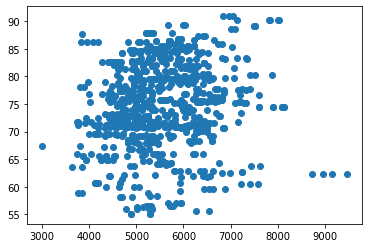

In [59]:
#compare measures before and after regression
plt.scatter(AD_data_Reg.Hippocampus, AD_data_Reg.AGE)
print(AD_data_Reg.AGE.corr(AD_data_Reg.Hippocampus))
plt.show()

-0.3410560810660916


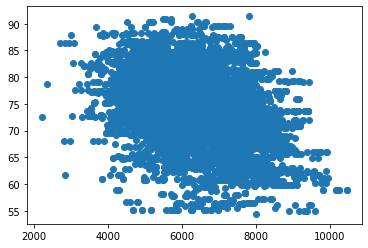

In [60]:
plt.scatter(ADNIMERGE1.Hippocampus, ADNIMERGE1.AGE)
print(ADNIMERGE1.AGE.corr(ADNIMERGE1.Hippocampus))
plt.show()

<AxesSubplot:xlabel='timeline'>

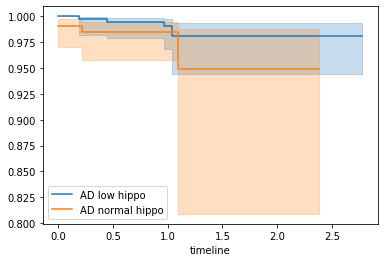

In [61]:
#Use z-score cut-off -1.63 to group patients with low or normal hippocampal vols
AD_data_ZGPlow_hippo=AD_data_Reg.loc[AD_data_Reg['Z_hippo']<-1.63]
AD_data_ZGPnormal_hippo=AD_data_Reg.loc[AD_data_Reg['Z_hippo']>=-1.63]

km.fit(AD_data_ZGPlow_hippo['Years_bl'], AD_data_ZGPlow_hippo['death'], label='AD low hippo')
a1 = km.plot()

# fit the model for 2nd cohort
km.fit(AD_data_ZGPnormal_hippo['Years_bl'], AD_data_ZGPnormal_hippo['death'], label='AD normal hippo')
km.plot(ax=a1)

In [62]:
from lifelines.statistics import logrank_test
results=logrank_test(AD_data_ZGPlow_hippo['Years_bl'],AD_data_ZGPhigh_hippo['Years_bl'],event_observed_A=AD_data_ZGPlow_hippo['Suvival'], event_observed_B=AD_data_ZGPhigh_hippo['Suvival'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.94 <0.005      9.27

<AxesSubplot:xlabel='timeline'>

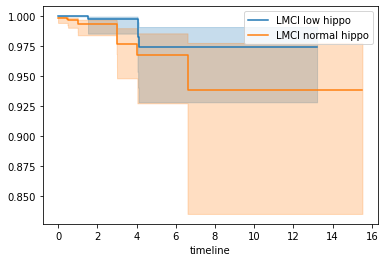

In [63]:
LMCI_data_ZGPlow_hippo=LMCI_data_Reg.loc[LMCI_data_Reg['Z_hippo']<-1.63]
LMCI_data_ZGPhigh_hippo=LMCI_data_Reg.loc[LMCI_data_Reg['Z_hippo']>=-1.63]

km.fit(LMCI_data_ZGPlow_hippo['Years_bl'], LMCI_data_ZGPlow_hippo['death'], label='LMCI low hippo')
a1 = km.plot()

# fit the model for 2nd cohort
km.fit(LMCI_data_ZGPhigh_hippo['Years_bl'], LMCI_data_ZGPhigh_hippo['death'], label='LMCI normal hippo')
km.plot(ax=a1)

In [64]:
results=logrank_test(LMCI_data_ZGPlow_hippo['Years_bl'],LMCI_data_ZGPhigh_hippo['Years_bl'],event_observed_A=LMCI_data_ZGPlow_hippo['Suvival'], event_observed_B=LMCI_data_ZGPhigh_hippo['Suvival'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.61 0.43      1.20

In [65]:
results=logrank_test(AD_data_ZGPlow_hippo['Years_bl'],AD_data_ZGPhigh_hippo['Years_bl'],event_observed_A=AD_data_ZGPlow_hippo['death'], event_observed_B=AD_data_ZGPhigh_hippo['death'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.90 0.05      4.38

In [66]:
def get_best_cutoff(data_ZGP,surv_col):
    cutoff=0
    p_val=0.9
    final_cutoff=0
    while cutoff>-3:
        data_ZGPlow_hippo=data_ZGP.loc[data_ZGP['Z_hippo']<cutoff]
        data_ZGPhigh_hippo=data_ZGP.loc[data_ZGP['Z_hippo']>=cutoff]


        results=logrank_test(data_ZGPlow_hippo['Years_bl'],data_ZGPhigh_hippo['Years_bl'],event_observed_A=data_ZGPlow_hippo[f'{surv_col}'], event_observed_B=data_ZGPhigh_hippo[f'{surv_col}'])
        current_p_val=results.p_value
        if current_p_val<p_val:
            p_val=current_p_val
            final_cutoff=cutoff
        cutoff=cutoff-0.1
    return round(p_val,3), round(final_cutoff,3)

In [67]:
AD_p_val,AD_final_cutoff=get_best_cutoff(AD_data_Reg,'death')
AD_p_val,AD_final_cutoff

(0.003, -0.5)

<AxesSubplot:xlabel='timeline'>

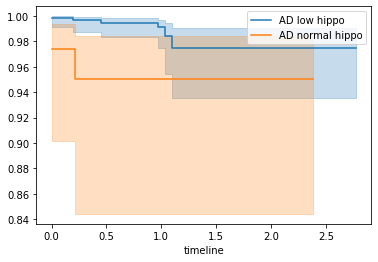

In [68]:
#Use the best z-score cut-off
AD_data_ZGPlow_hippo=AD_data_Reg.loc[AD_data_Reg['Z_hippo']<AD_final_cutoff]
AD_data_ZGPhigh_hippo=AD_data_Reg.loc[AD_data_Reg['Z_hippo']>=AD_final_cutoff]

km.fit(AD_data_ZGPlow_hippo['Years_bl'], AD_data_ZGPlow_hippo['death'], label='AD low hippo')
a1 = km.plot()

# fit the model for 2nd cohort
km.fit(AD_data_ZGPhigh_hippo['Years_bl'],AD_data_ZGPhigh_hippo['death'], label='AD normal hippo')
km.plot(ax=a1)

0.001 -1.7


<AxesSubplot:xlabel='timeline'>

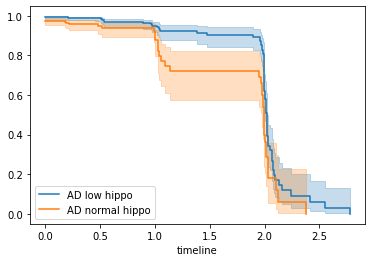

In [69]:
AD_p_val,AD_final_cutoff=get_best_cutoff(AD_data_Reg,'Suvival')
print(AD_p_val,AD_final_cutoff)
AD_data_ZGPlow_hippo=AD_data_Reg.loc[AD_data_Reg['Z_hippo']<AD_final_cutoff]
AD_data_ZGPhigh_hippo=AD_data_Reg.loc[AD_data_Reg['Z_hippo']>=AD_final_cutoff]

km.fit(AD_data_ZGPlow_hippo['Years_bl'], AD_data_ZGPlow_hippo['Suvival'], label='AD low hippo')
a1 = km.plot()

# fit the model for 2nd cohort
km.fit(AD_data_ZGPhigh_hippo['Years_bl'],AD_data_ZGPhigh_hippo['Suvival'], label='AD normal hippo')
km.plot(ax=a1)

In [70]:
LMCI_p_val,LMCI_final_cutoff=get_best_cutoff(LMCI_data_Reg,'death')
LMCI_p_val,LMCI_final_cutoff

(0.006, -0.7)

<AxesSubplot:xlabel='timeline'>

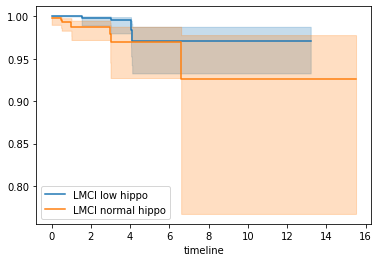

In [71]:
LMCI_data_ZGPlow_hippo=LMCI_data_Reg.loc[LMCI_data_Reg['Z_hippo']<LMCI_final_cutoff]
LMCI_data_ZGPhigh_hippo=LMCI_data_Reg.loc[LMCI_data_Reg['Z_hippo']>=LMCI_final_cutoff]

km.fit(LMCI_data_ZGPlow_hippo['Years_bl'], LMCI_data_ZGPlow_hippo['death'], label='LMCI low hippo')
a1 = km.plot()

# fit the model for 2nd cohort
km.fit(LMCI_data_ZGPhigh_hippo['Years_bl'], LMCI_data_ZGPhigh_hippo['death'], label='LMCI normal hippo')
km.plot(ax=a1)

In [72]:
results=logrank_test(LMCI_data_ZGPlow_hippo['Years_bl'],LMCI_data_ZGPhigh_hippo['Years_bl'],event_observed_A=LMCI_data_ZGPlow_hippo['death'], event_observed_B=LMCI_data_ZGPhigh_hippo['death'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.45 0.01      7.30